In [595]:
import pandas as pd
import numpy as np
import os
pd.options.display.max_rows = 200

In [596]:
os.chdir(r'C:\Users\Administrator\Desktop\02.Analyses')
from myfuncs import *

# Carregando as bases 

In [606]:
os.chdir(r'C:\Users\Administrator\Desktop\01.Data')
# rAcertos = pd.read_csv(r'ENEM_ACERTOS_QUESTOES_20180912_0300.csv',sep = ';',encoding='latin-1')
rCenso = pd.read_csv(r'base_old.csv',sep = ',',encoding = 'utf-8')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (4,6,7,9,10,11,12,13,14,15,16,17,18,23,24,25,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Base de relacao de area e questao 

In [607]:
rArea = pd.read_excel('provas ENEM 2017 (1).xlsx')

# Analisando as bases

## Criando base de infos detalhadas de escola 

### Agrupando informacoes de Censo a nível escola

In [608]:
tCenso = rCenso.copy()

#filtrar colunas
disc_columns = [c for c in list(rCenso.filter(regex = 'IN_DISC').columns) if c != 'IN_DISC_MATEMATICA']
other_columns = ['IN_EDUCACAO_INDIGENA','IN_ESPECIAL_EXCLUSIVA','IN_ESPECIFICO_EJA','IN_MANT_ESCOLA_PRIVADA_EMP',
                'IN_MANT_ESCOLA_PRIVADA_ONG','IN_MANT_ESCOLA_PRIVADA_SIND','IN_MANT_ESCOLA_PRIVADA_SIST_S',
                'IN_MANT_ESCOLA_PRIVADA_S_FINS','CONVENIO_ESCOLA','CO_PESSOA_FISICA','CO_UF',
                'ID_MATRICULA','ID_TURMA','IN_CONVENIADA_PP','IDADE_DOCENTE','NU_IDADE_REFERENCIA',
                'TP_CATEGORIA_ESCOLA_PRIVADA','TP_CONVENIO_PODER_PUBLICO','TP_LOCALIZACAO','TP_NORMAL_MAGISTERIO','TP_MEDIACAO_DIDATICO_PEDAGO',
                'TP_SITUACAO_CURSO_1','TP_ZONA_RESIDENCIAL','IN_ESPECIFICO_ANOS_INICIAIS','IN_ESPECIFICO_ANOS_FINAIS','NU_DIAS_ATIVIDADE',
                'NU_IDADE','TP_TIPO_CONTRATACAO','TP_TIPO_DOCENTE','NU_MATRICULAS','TP_DEPENDENCIA','NO_ENTIDADE']

tCenso.drop(disc_columns,axis = 1,inplace = True)
tCenso.drop(other_columns,axis = 1,inplace = True)

#criando dummies para categoricos
dummy_columns = ['ESCOLARIDADE_DOCENTE','SEXO_DOCENTE','TP_COR_RACA_ALUNO','TP_COR_RACA_DOCENTE','TIPO_LOCALIAZCAO_ESCOLA',
                'TP_SEXO_ALUNO']
for dc in dummy_columns:
    dummies = pd.get_dummies(tCenso[dc],prefix = dc + '_')
    tCenso = tCenso.drop(dc,axis  = 1)
    tCenso = pd.concat([tCenso,dummies],axis=1)

#conversao  de flag
flag_columns = ['IN_DISC_MATEMATICA','IN_ESPECIALIZACAO','IN_MESTRADO','IN_DOUTORADO','IN_ESPECIFICO_ENS_MEDIO']
for fc in flag_columns:
    print(fc)
    tCenso[fc] = tCenso[fc].str.replace('Não','0')
    tCenso[fc] = tCenso[fc].str.replace('Sim','1')
    tCenso[fc] = tCenso[fc].astype('float')

#definindo funcao agregado
aggregator = {}
first_columns = ['CO_UF','TIPO_LOCALIAZCAO_ESCOLA','NO_ENTIDADE']

#criando dicionario agregador
for c in tCenso.columns:
    if c != 'CO_ENTIDADE':
        if c in first_columns:
            aggregator[c] = 'first'
        else:
            aggregator[c] = 'mean'
        
#agrupando conforme dados
tCenso = tCenso.groupby('CO_ENTIDADE').agg(aggregator).reset_index()

#filtrando escolas que nao temos informacoes sobre existencia de professores de escola de matematica
tCenso = tCenso[tCenso['IN_DISC_MATEMATICA'].notnull()]

IN_DISC_MATEMATICA
IN_ESPECIALIZACAO
IN_MESTRADO
IN_DOUTORADO
IN_ESPECIFICO_ENS_MEDIO


### Agrupando informacoes de acertos a nivel escola

In [609]:
tAcertos = rAcertos.copy()
tAcertos = tAcertos[tAcertos['CO_ESCOLA'].notnull()]

aggregator = {}
#criando funcao agrupadora
for c in tAcertos.columns:
    if 'CHECK_' in c:
        aggregator[c] = 'mean'
    elif 'ACERTOS' in c:
        aggregator[c] = 'mean'
    elif 'NU_INSCRICAO' in  c:
        aggregator[c] = 'count'
        
tAcertos = tAcertos.groupby('CO_ESCOLA').agg(aggregator).reset_index()

#renomeando informacoes
tAcertos.rename(columns =  {"NU_INSCRICAO":'n_inscricoes'},inplace = True)
print(tCenso.shape)
tMT = tCenso.merge(tAcertos,left_on='CO_ENTIDADE',right_on ='CO_ESCOLA',how = "left")
tMT = tMT[tMT['CHECK_1'].notnull()]

print(tMT.shape)

(2544, 23)
(753, 71)


### Enriquecendo com informacoes de grupos de questoes

In [610]:
def mean_col_group(df,index_list):
    cols_list = []
    for i in index_list:
        cols_list.append('CHECK_'+str(i))
    return df[cols_list].mean(axis=1)

##### Limpando a base de DEPARA entre questao e área

In [611]:
tArea = rArea.copy()
tArea = tArea.drop(0,axis = 0).reset_index(drop=True)
tArea = tArea[["CÓDIGO",403]]
tArea = tArea.sort_values('CÓDIGO')
tArea

,CÓDIGO,403
0,Aritmética,1
1,Aritmética,2
40,Aritmética,41
21,Geometria Espacial,22
12,Geometria Espacial,13
8,Geometria Espacial,9
22,Geometria Espacial,23
6,Geometria Espacial,7
31,Geometria Espacial; Geometria Plana,32
25,Geometria Plana,26


##### Agregando por área de conhecimento de matemática

In [614]:
tMT['CHECK_ARITMETICA'] = mean_col_group(tMT,[1,2,41])
tMT['CHECK_GEOESP'] = mean_col_group(tMT,[22,13,19,23,7])
tMT['CHECK_GEOPLAN'] = mean_col_group(tMT,[32,26,31,27,33,18,21,5,15,3])
tMT['CHECK_LOGICA'] = mean_col_group(tMT,[34,17,19,37,35,24,28])
tMT['CHECK_PROB_E_ESTAT'] = mean_col_group(tMT,[43,42,39,44,14,40,25])
tMT['CHECK_ALGEBRA'] = mean_col_group(tMT,[36,38,8,29,4,20,16,12,11,10,6,30,45])


### Enriquecendo com dados geolocalizacao

In [612]:
rGeo = pd.read_csv(r'escolasr34dez2017.csv',sep = ';',encoding = 'latin-1')
tGeo = rGeo[['CODINEP','CEP','LATITUDE','LONGITUDE']]

In [613]:
tMT['CO_ENTIDADE'] = tMT['CO_ENTIDADE'].astype('float')
tMT  = tMT.merge(tGeo, left_on = 'CO_ENTIDADE',right_on = 'CODINEP', how = 'left')

#####  Calculando estatisticas 

In [615]:
#criando max,mean e min
tMT.loc['MAX',:]= tMT.max(axis= 0)
tMT.loc['MEAN',:]= tMT.mean(axis= 0)
tMT.loc['MIN',:]= tMT.min(axis= 0)

tMT.loc['MAX','CO_ENTIDADE']= 99999999
tMT.loc['MEAN','CO_ENTIDADE']= 99999998
tMT.loc['MIN','CO_ENTIDADE']= 99999997

##### Exportando csv 

# Gerando plots 

EEEB LOURENCO LEON VON LANGENDONCK
43093809.0


,CHECK_ARITMETICA,CHECK_GEOESP,CHECK_GEOPLAN,CHECK_LOGICA,CHECK_PROB_E_ESTAT,CHECK_ALGEBRA,n_inscricoes
560,0.185185,0.37037,0.255556,0.248677,0.222222,0.25641,27.0


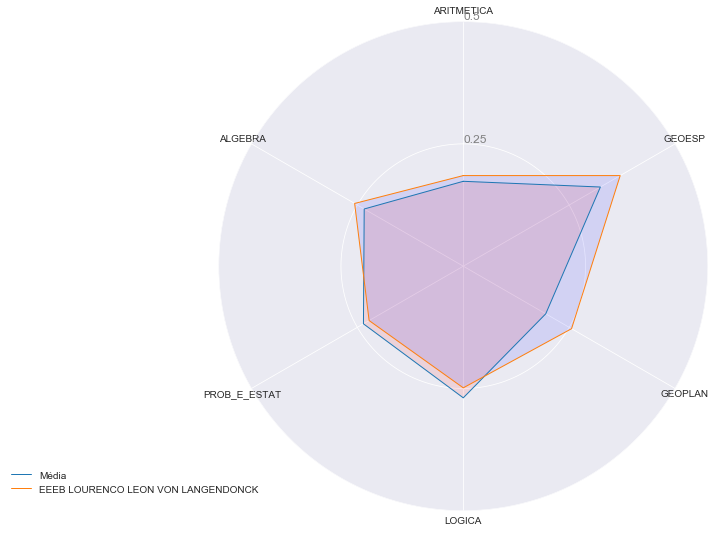

In [680]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
 
# ------- PART 1: Create background
 
# number of variable
# categories=list(tMT)[1:]
categories = ['CHECK_ARITMETICA','CHECK_GEOESP','CHECK_GEOPLAN','CHECK_LOGICA','CHECK_PROB_E_ESTAT','CHECK_ALGEBRA']
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
plt.figure(figsize = (12,9))
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], [c.replace('CHECK_',"") for c in categories])
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.25,0.5], ["0.25",'0.5'], color="grey", size=12)
plt.ylim(0,0.5)
 
 
# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values = tMT[tMT['CO_ENTIDADE'] == 99999998][categories].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Média")
ax.fill(angles, values, 'r', alpha=0.1)
 
# # Ind2
subset = tMT[tMT['n_inscricoes'] > 20]
# selected_entidade = subset['CO_ENTIDADE'].sample().values[0]
selected_entidade = 43093809.0
nome_entidade = rCenso[rCenso['CO_ENTIDADE'] == selected_entidade]['NO_ENTIDADE'].values[0]
values = tMT[tMT['CO_ENTIDADE'] == selected_entidade][categories].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label=nome_entidade)
ax.fill(angles, values, 'b', alpha=0.1)
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

print(nome_entidade)
print(selected_entidade)
display(tMT[tMT['CO_ENTIDADE'] == selected_entidade][categories + ['n_inscricoes'] ])